In [1]:
pip install pandas numpy matplotlib seaborn scikit-learn

In [5]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print(f'User uploaded file "{fn}" with length {len(uploaded[fn])} bytes')

Saving Titanic-Dataset.csv to Titanic-Dataset.csv
User uploaded file "Titanic-Dataset.csv" with length 61194 bytes


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
#Imported Reqd. Libs

# Loading the dataset
df = pd.read_csv("Titanic-Dataset.csv")

Dataset Shape: (891, 12)

Data Types:
 PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Statistical Summary:
         PassengerId    Survived      Pclass                 Name   Sex  \
count    891.000000  891.000000  891.000000                  891   891   
unique          NaN         NaN         NaN                  891     2   
top             NaN         NaN         NaN  Dooley, Mr. Patrick  male   
freq            NaN         NaN         NaN                    1   577   
mean     446.000000

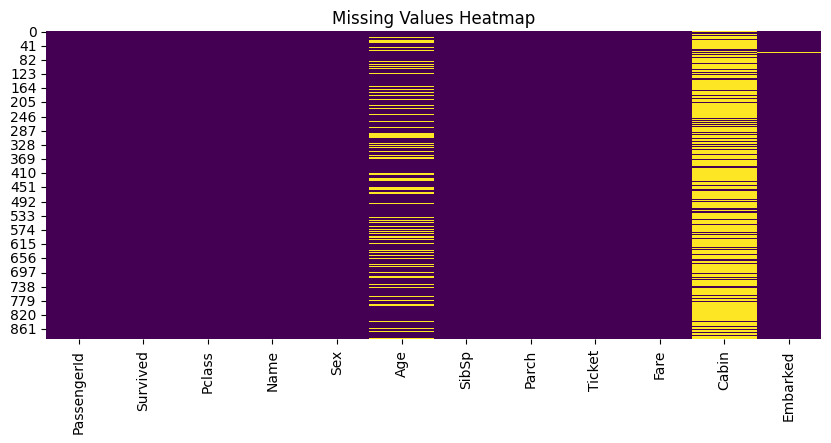

In [7]:
# Basic info about the data to help us understand the dataset
print("Dataset Shape:", df.shape)
print("\nData Types:\n", df.dtypes)
print("\nMissing Values:\n", df.isnull().sum())
print("\nStatistical Summary:\n", df.describe(include='all'))

# Visualizing the missing data
plt.figure(figsize=(10, 4))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.savefig('missing_values.png', bbox_inches='tight')
plt.show()

In [9]:
# After checking the figure we:
# - Drop Cabin (too many missing)
# - Impute Age with median
# - Impute Embarked with mode

df_clean = df.copy()

# Dropping irrelevant columns
df_clean.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1, inplace=True)

# Imputing Age
age_imputer = SimpleImputer(strategy='median')
df_clean['Age'] = age_imputer.fit_transform(df_clean[['Age']])

# Imputing Embarked
embarked_imputer = SimpleImputer(strategy='most_frequent')
df_clean['Embarked'] = embarked_imputer.fit_transform(df_clean[['Embarked']]).ravel()

# Verifying after Imputing
print("\nAfter Imputation:\n", df_clean.isnull().sum())


After Imputation:
 Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [10]:
#Categorical columns
cat_cols = ['Sex', 'Embarked']
#Numerical columns
num_cols = ['Age', 'Fare']

# One-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), cat_cols),
        ('num', 'passthrough', num_cols)
    ])

# Apply transformation
encoded_data = preprocessor.fit_transform(df_clean)

# Getting feature names
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(cat_cols)
all_features = np.concatenate([cat_features, num_cols])

df_processed = pd.DataFrame(encoded_data, columns=all_features)

# Adding untouched columns
other_cols = ['Survived', 'Pclass', 'SibSp', 'Parch']
df_processed = pd.concat([df_clean[other_cols], df_processed], axis=1)

print("\nProcessed Data Head:\n", df_processed.head())


Processed Data Head:
    Survived  Pclass  SibSp  Parch  Sex_male  Embarked_Q  Embarked_S   Age  \
0         0       3      1      0       1.0         0.0         1.0  22.0   
1         1       1      1      0       0.0         0.0         0.0  38.0   
2         1       3      0      0       0.0         0.0         1.0  26.0   
3         1       1      1      0       0.0         0.0         1.0  35.0   
4         0       3      0      0       1.0         0.0         1.0  35.0   

      Fare  
0   7.2500  
1  71.2833  
2   7.9250  
3  53.1000  
4   8.0500  


In [11]:
scaler = StandardScaler()
df_processed[['Age', 'Fare']] = scaler.fit_transform(df_processed[['Age', 'Fare']])

print("\nAfter Scaling:\n", df_processed[['Age', 'Fare']].describe().loc[['mean', 'std']])


After Scaling:
                Age          Fare
mean  2.272780e-16  3.987333e-18
std   1.000562e+00  1.000562e+00


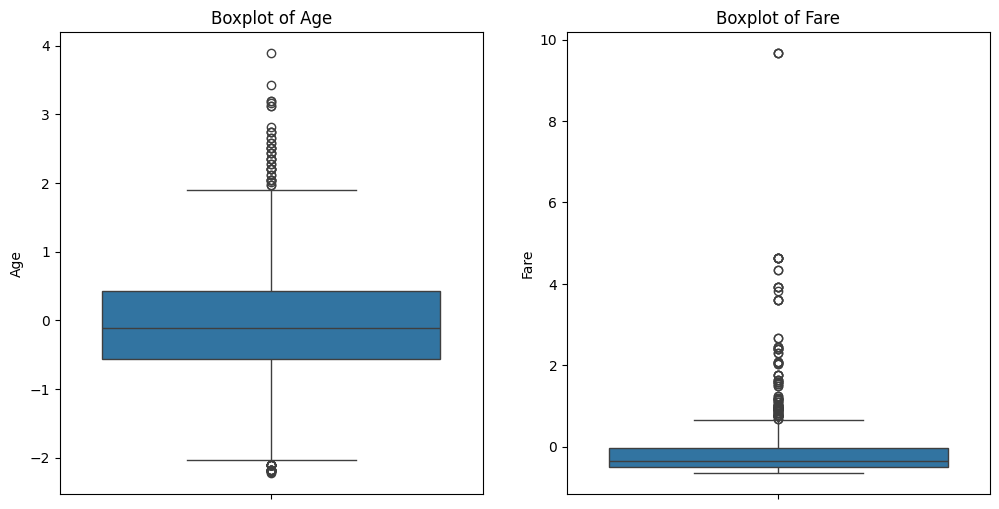

In [12]:
plt.figure(figsize=(12, 6))
for i, col in enumerate(['Age', 'Fare']):
    plt.subplot(1, 2, i+1)
    sns.boxplot(y=df_processed[col])
    plt.title(f'Boxplot of {col}')
plt.savefig('outliers.png', bbox_inches='tight')
plt.show()

# Cap outliers at 95th percentile
for col in ['Fare']:
    upper_limit = df_processed[col].quantile(0.95)
    df_processed[col] = np.where(
        df_processed[col] > upper_limit,
        upper_limit,
        df_processed[col]
    )

In [13]:
# Save cleaned data
df_processed.to_csv('titanic_cleaned.csv', index=False)

# Verify final structure
print("\nFinal Dataset Info:")
print(f"Shape: {df_processed.shape}")
print(f"Columns: {df_processed.columns.tolist()}")
print(f"Missing Values: {df_processed.isnull().sum().sum()}")


Final Dataset Info:
Shape: (891, 9)
Columns: ['Survived', 'Pclass', 'SibSp', 'Parch', 'Sex_male', 'Embarked_Q', 'Embarked_S', 'Age', 'Fare']
Missing Values: 0


In [15]:
# Printing the first 20 rows of cleaned data
print("Cleaned Dataset Sample:")
print(df_processed.head(20))

print("\nDataset Summary:")
print(df_processed.describe())
print("\nFeature Information:")
print(f"Total Features: {len(df_processed.columns)}")
print(f"Features: {', '.join(df_processed.columns)}")

Cleaned Dataset Sample:
    Survived  Pclass  SibSp  Parch  Sex_male  Embarked_Q  Embarked_S  \
0          0       3      1      0       1.0         0.0         1.0   
1          1       1      1      0       0.0         0.0         0.0   
2          1       3      0      0       0.0         0.0         1.0   
3          1       1      1      0       0.0         0.0         1.0   
4          0       3      0      0       1.0         0.0         1.0   
5          0       3      0      0       1.0         1.0         0.0   
6          0       1      0      0       1.0         0.0         1.0   
7          0       3      3      1       1.0         0.0         1.0   
8          1       3      0      2       0.0         0.0         1.0   
9          1       2      1      0       0.0         0.0         0.0   
10         1       3      1      1       0.0         0.0         1.0   
11         1       1      0      0       0.0         0.0         1.0   
12         0       3      0      0      

/tmp/ipython-input-16-1660173672.py:25: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df_clean['Fare'], df_processed['Fare']],
/tmp/ipython-input-16-1660173672.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Sex_male', y='Survived', data=df_processed,


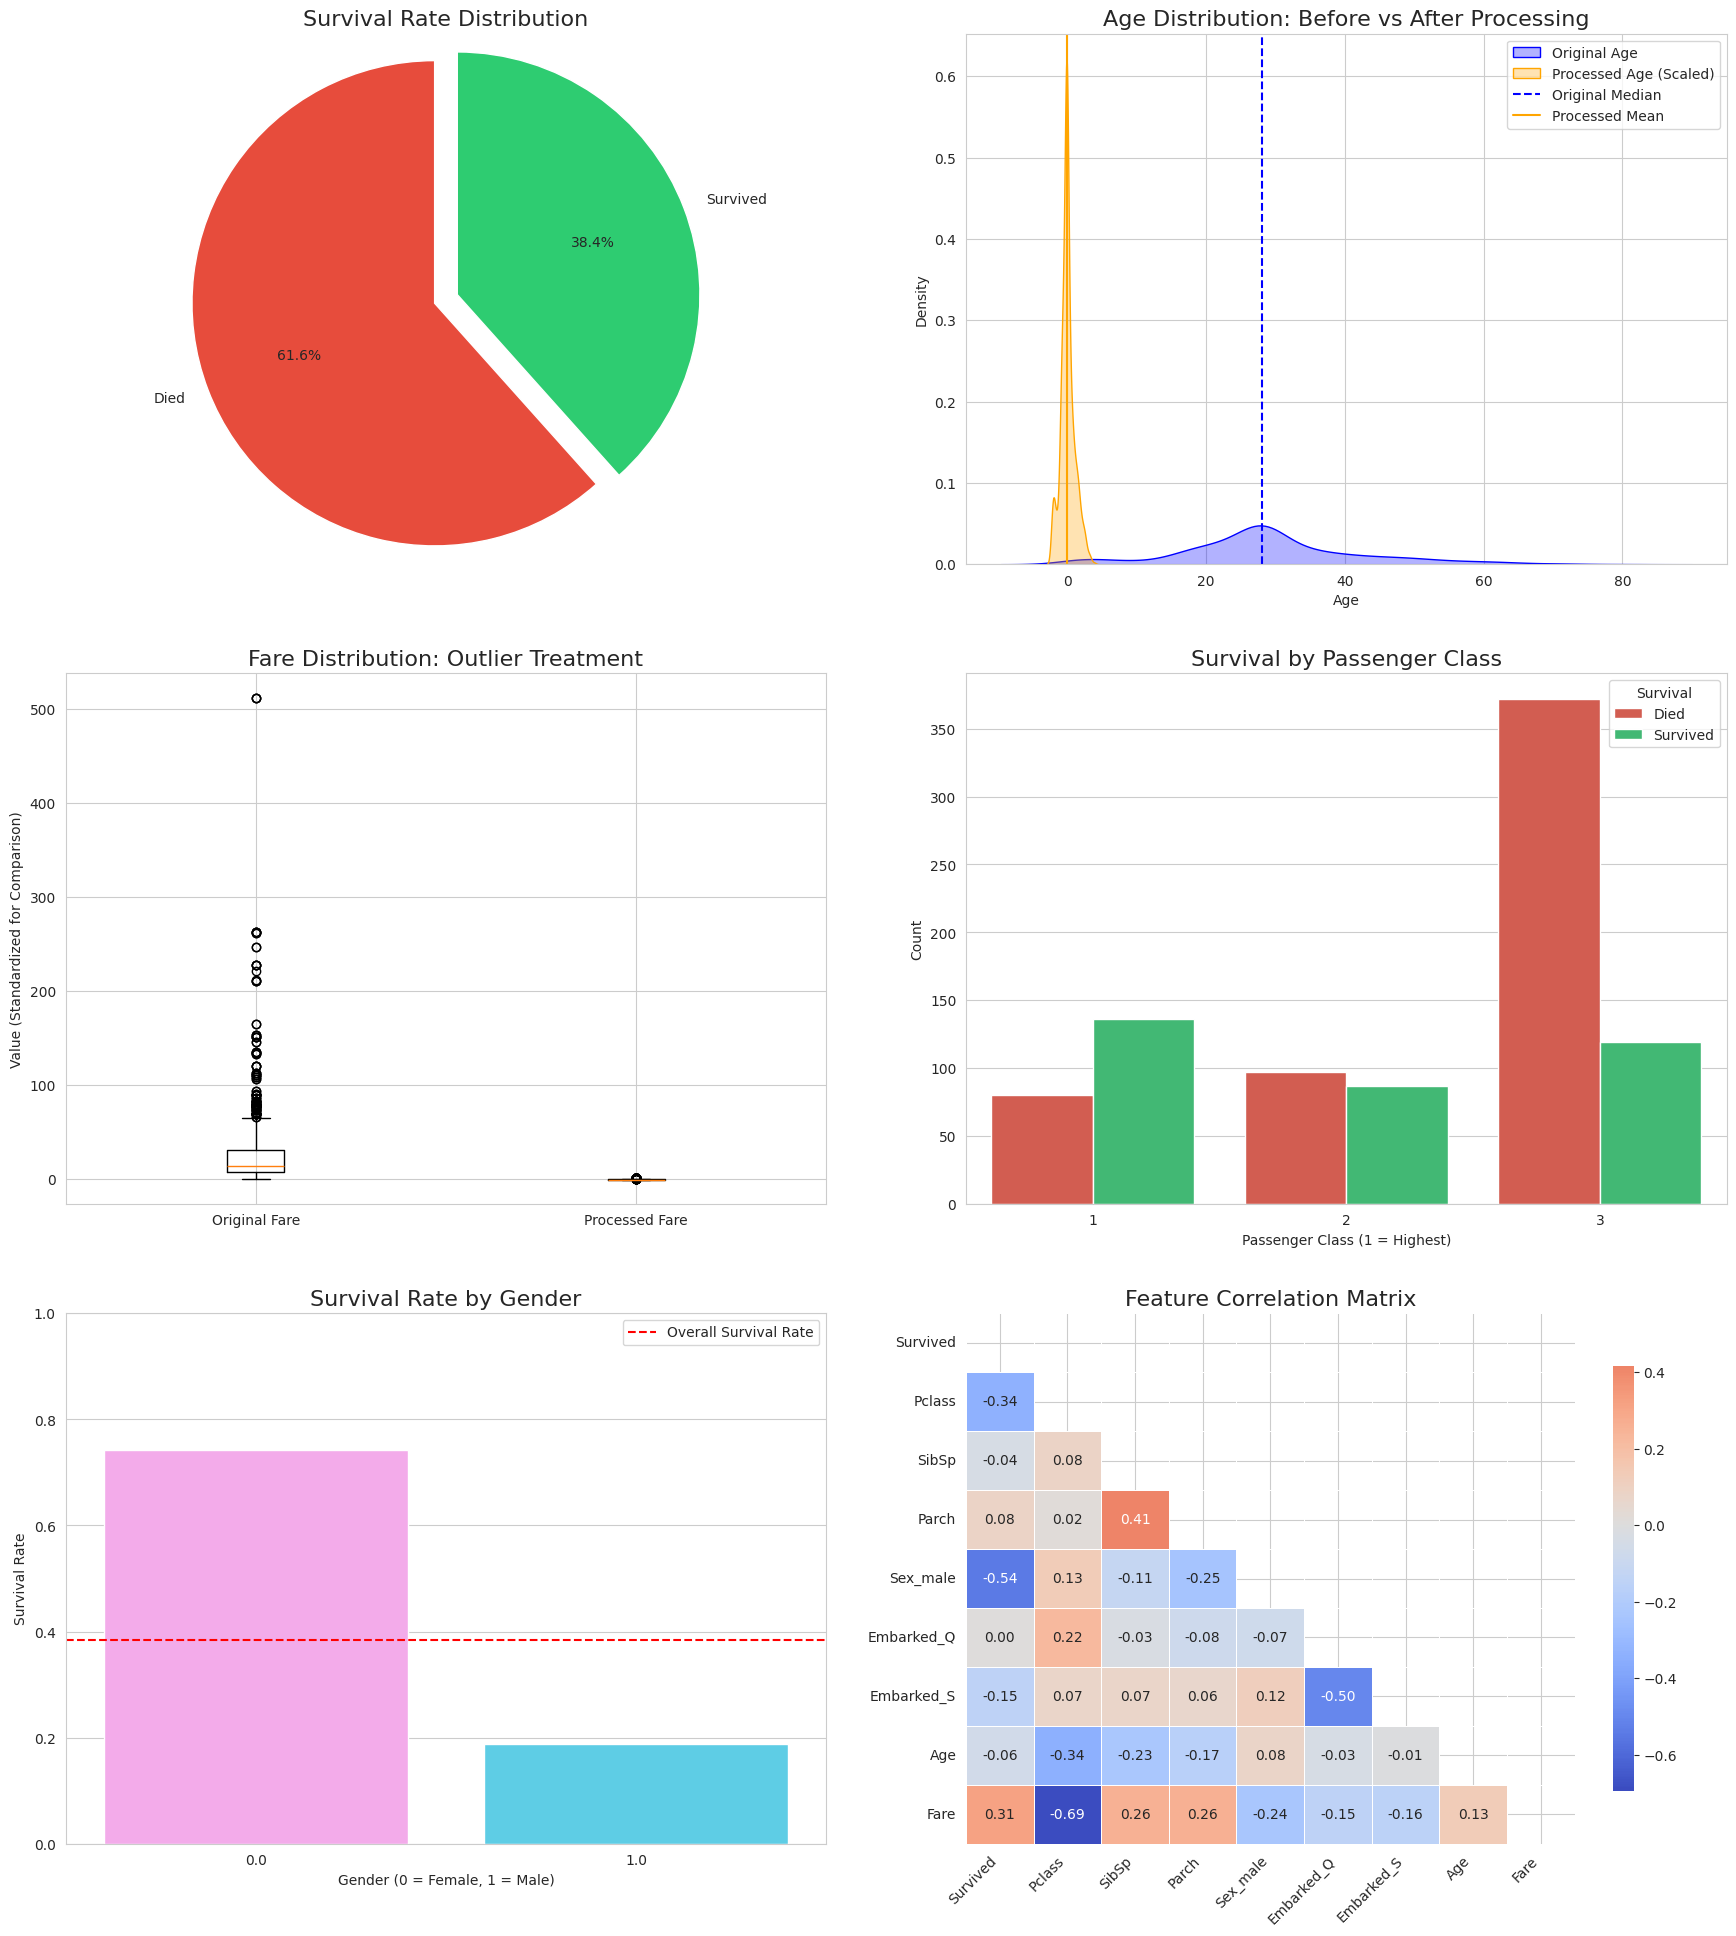

In [16]:
#Full Visual Analysis
sns.set_style("whitegrid")
plt.figure(figsize=(18, 20))

# 1. Survival Distribution (Target Variable)
plt.subplot(3, 2, 1)
survived_counts = df_processed['Survived'].value_counts()
plt.pie(survived_counts, labels=['Died', 'Survived'], autopct='%1.1f%%',
        colors=['#e74c3c', '#2ecc71'], startangle=90, explode=(0, 0.1))
plt.title('Survival Rate Distribution', fontsize=16)
plt.axis('equal')

# 2. Feature Distribution Comparison
plt.subplot(3, 2, 2)
sns.kdeplot(df_clean['Age'], label='Original Age', fill=True, alpha=0.3, color='blue')
sns.kdeplot(df_processed['Age'], label='Processed Age (Scaled)', fill=True, alpha=0.3, color='orange')
plt.axvline(df_clean['Age'].median(), color='blue', linestyle='--', label='Original Median')
plt.axvline(df_processed['Age'].mean(), color='orange', linestyle='-', label='Processed Mean')
plt.title('Age Distribution: Before vs After Processing', fontsize=16)
plt.xlabel('Age')
plt.legend()

# 3. Outlier Treatment Visualization
plt.subplot(3, 2, 3)
plt.boxplot([df_clean['Fare'], df_processed['Fare']],
           labels=['Original Fare', 'Processed Fare'])
plt.title('Fare Distribution: Outlier Treatment', fontsize=16)
plt.ylabel('Value (Standardized for Comparison)')
plt.grid(True)

# 4. Passenger Class vs Survival
plt.subplot(3, 2, 4)
sns.countplot(x='Pclass', hue='Survived', data=df_processed,
             palette={0: '#e74c3c', 1: '#2ecc71'})
plt.title('Survival by Passenger Class', fontsize=16)
plt.xlabel('Passenger Class (1 = Highest)')
plt.ylabel('Count')
plt.legend(title='Survival', labels=['Died', 'Survived'])

# 5. Gender vs Survival
plt.subplot(3, 2, 5)
sns.barplot(x='Sex_male', y='Survived', data=df_processed,
           palette=['#ff9ff3', '#48dbfb'], errorbar=None)
plt.title('Survival Rate by Gender', fontsize=16)
plt.xlabel('Gender (0 = Female, 1 = Male)')
plt.ylabel('Survival Rate')
plt.ylim(0, 1)
plt.axhline(df_processed['Survived'].mean(), color='red', linestyle='--',
            label='Overall Survival Rate')
plt.legend()

# 6. Correlation Matrix
plt.subplot(3, 2, 6)
corr = df_processed.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='coolwarm',
           center=0, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Feature Correlation Matrix', fontsize=16)
plt.xticks(rotation=45, ha='right')

plt.tight_layout(pad=3.0)
plt.savefig('titanic_data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()